In [2]:
%matplotlib inline

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from numba import jit
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor


# @jit
def _find_best_split_feature(argsort_x, feature_num, feature_val, min_error, num, sorted_y, tmp, values_list,
                             x):
    l_size, l_sq_sum, l_sum, r_size, r_sq_sum, r_sum = _init_sums(sorted_y, values_list)
    for val_num in values_list:
        err = _get_mse(r_sum, r_sq_sum, r_size) + _get_mse(l_sum, l_sq_sum, l_size)

        l_size, l_sq_sum, l_sum, r_size, r_sq_sum, r_sum = _change_sums(l_size, l_sq_sum, l_sum, r_size,
                                                                        r_sq_sum, r_sum, sorted_y[val_num])
        
        if not min_error or min_error > err:
            feature_num = num
            feature_val = x[argsort_x[val_num, num], num]
            tmp = val_num
            min_error = err
            
        print "feature:" + str (num) + "value:" + str(sorted_y[val_num]) + "error:" + str(err)
    return feature_num, feature_val, min_error, tmp


# @jit
def _init_sums(sorted_y, values_list):
    r_size = sorted_y[:values_list[0]].size
    l_size = sorted_y[values_list[0]:].size
    r_sum = sorted_y[:values_list[0]].sum()
    l_sum = sorted_y[values_list[0]:].sum()
    r_sq_sum = (sorted_y[:values_list[0]] ** 2).sum()
    l_sq_sum = (sorted_y[values_list[0]:] ** 2).sum()
    return l_size, l_sq_sum, l_sum, r_size, r_sq_sum, r_sum


# @jit
def _change_sums(l_size, l_sq_sum, l_sum, r_size, r_sq_sum, r_sum, changing_val):
    r_sum += changing_val
    l_sum -= changing_val
    r_sq_sum += changing_val * changing_val
    l_sq_sum -= changing_val * changing_val
    r_size += 1
    l_size -= 1
    return l_size, l_sq_sum, l_sum, r_size, r_sq_sum, r_sum


# @jit
def _get_mse(el_sum, sq_sum,  num):
    res = (sq_sum - (el_sum * el_sum) / num) / num
    if res < 0:
        raise 1
    return res


# @jit
def load_data():
    all_data = pd.read_csv("auto-mpg.data",
                           delim_whitespace=True, header=None,
                           names=['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration',
                                  'model', 'origin', 'car_name'])
    all_data = all_data.dropna()
    y = np.array(all_data['mpg'])
    columns = ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration',
               'model', 'origin']
    X = np.array(all_data[columns])
    return X, y


class MyDecisionTreeRegressor:
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1

    def __init__(self, min_samples_split=2, max_depth=None):
        self.tree = dict()
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth

    def __find_threshold(self, x, y):
        argsort_x = x.argsort(axis=0)

        min_error = None
        feature_num = None
        feature_val = None
        tmp = None

        values_list = range(self.min_samples_split, x.shape[0] - self.min_samples_split)
        if len(values_list) == 0:
            return None

        for num in range(x.shape[1]):
            sorted_y = y[argsort_x[:, num]]
            print num
            feature_num, feature_val, min_error, tmp = _find_best_split_feature(argsort_x, feature_num,
                                                                                feature_val, min_error, num,
                                                                                sorted_y, tmp, values_list, x)
        
        print "min_error:",min_error,"f_num:",feature_num,"f_val:",feature_val
        if min_error is None:
            raise 1

        return feature_num, feature_val, \
               x[argsort_x[:, feature_num]][:tmp], \
               x[argsort_x[:, feature_num]][tmp:], \
               y[argsort_x[:, feature_num]][:tmp], \
               y[argsort_x[:, feature_num]][tmp:]

    def __fit_node(self, x, y, node_id, depth, pred_f=-1):
        if self.max_depth is not None and depth == self.max_depth:
            self.tree[node_id] = (self.LEAF_TYPE, np.mean(y))
            return x,y
        if self.min_samples_split is not None and x.shape[0] <= self.min_samples_split:
            self.tree[node_id] = (self.LEAF_TYPE, np.mean(y))
            return x,y

        res = self.__find_threshold(x, y)
        if res is None:
            self.tree[node_id] = (self.LEAF_TYPE, np.mean(y))
            return x,y

        feature_num, feature_val, x_l, x_r, y_l, y_r = res

        if y_l.size < self.min_samples_split or y_r.size < self.min_samples_split:
            self.tree[node_id] = (self.LEAF_TYPE, np.mean(y))
            return x,y

        self.tree[node_id] = (self.NON_LEAF_TYPE, feature_num, feature_val)
        return self.__fit_node(x_l, y_l, 2 * node_id + 1, depth + 1), self.__fit_node(x_r, y_r, 2 * node_id + 2, depth + 1)

    def fit(self, x, y):
        return self.__fit_node(x, y, 0, 0)

    def __predict(self, x, node_id):
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_num, feature_val = node
            if x[feature_num] < feature_val:
                return self.__predict(x, 2 * node_id + 1)
            else:
                return self.__predict(x, 2 * node_id + 2)
        else:
            return node[1]

    def predict(self, X):
        return np.array([self.__predict(x, 0) for x in X])

    def fit_predict(self, x_train, y_train, predicted_x):
        self.fit(x_train, y_train)
        return self.predict(predicted_x)

In [91]:
X, y = load_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

tree_0 = MyDecisionTreeRegressor(max_depth=1)
tree_1 = MyDecisionTreeRegressor(max_depth=1)
tree_2 = MyDecisionTreeRegressor(max_depth=1)

In [92]:
first = tree_0.fit (X_train,y_train)


0
feature:0value:19.0error:66.3600822485
feature:0value:33.7error:69.0074001083
feature:0value:26.6error:96.3077762379
feature:0value:24.0error:91.0210927039
feature:0value:30.0error:87.1168532817
feature:0value:30.9error:87.5176303619
feature:0value:28.0error:88.0277025467
feature:0value:25.0error:86.0639521448
feature:0value:27.0error:84.4769408163
feature:0value:32.4error:83.0779870686
feature:0value:26.0error:84.4678058489
feature:0value:34.5error:83.3625277374
feature:0value:24.0error:85.9150294622
feature:0value:31.3error:85.5602617202
feature:0value:36.0error:85.4311171426
feature:0value:30.0error:88.0819381117
feature:0value:33.5error:87.1956773783
feature:0value:33.0error:87.4571322985
feature:0value:34.1error:87.3319110016
feature:0value:21.5error:87.5138839648
feature:0value:30.0error:89.0865502626
feature:0value:29.0error:88.2659227126
feature:0value:46.6error:87.4859908951
feature:0value:37.0error:97.1107435244
feature:0value:44.6error:97.5003960373
feature:0value:31.0erro

In [77]:
first[1][0]

array([[  6.00000000e+00,   2.00000000e+02,   8.50000000e+01,
          2.99000000e+03,   1.82000000e+01,   7.90000000e+01,
          1.00000000e+00],
       [  6.00000000e+00,   2.00000000e+02,   9.50000000e+01,
          3.15500000e+03,   1.82000000e+01,   7.80000000e+01,
          1.00000000e+00],
       [  6.00000000e+00,   2.00000000e+02,   8.80000000e+01,
          3.06000000e+03,   1.71000000e+01,   8.10000000e+01,
          1.00000000e+00],
       [  6.00000000e+00,   2.00000000e+02,   8.50000000e+01,
          2.96500000e+03,   1.58000000e+01,   7.80000000e+01,
          1.00000000e+00],
       [  6.00000000e+00,   2.00000000e+02,   8.10000000e+01,
          3.01200000e+03,   1.76000000e+01,   7.60000000e+01,
          1.00000000e+00],
       [  6.00000000e+00,   2.00000000e+02,   8.50000000e+01,
          3.07000000e+03,   1.67000000e+01,   7.80000000e+01,
          1.00000000e+00],
       [  6.00000000e+00,   2.25000000e+02,   1.05000000e+02,
          3.12100000e+03,   1.65

In [96]:
x_small_test = np.array ([[0,0],[0,1],[1,0],[1,1]])
y_small_test = np.array ([0,1,10,11])

In [99]:
small_tree = MyDecisionTreeRegressor(max_depth=2, min_samples_split=1)
small_tree.fit (x_small_test, y_small_test)
small_tree.tree

0
feature:0value:1error:20
feature:0value:10error:0
1
feature:1value:10error:20
feature:1value:1error:50
min_error: 20 f_num: 1 f_val: 0
0
feature:0value:10error:0
1
feature:1value:1error:25
min_error: 25 f_num: 1 f_val: 1


{0: (0, 1, 0), 1: (1, 0.0), 2: (0, 1, 1), 5: (1, 10.0), 6: (1, 6.0)}

In [93]:
# sec = tree_1.fit (first[0][0], first[0][1])
fas = tree_2.fit (first[1][0], first[1][1])

0
feature:0value:18.0error:14.4946514566
feature:0value:20.2error:14.9840974585
feature:0value:18.0error:15.1599876885
feature:0value:16.0error:15.3775240034
feature:0value:19.0error:16.6189724171
feature:0value:18.0error:16.45112148
feature:0value:22.0error:16.3902652893
feature:0value:18.0error:17.2890889178
feature:0value:17.5error:17.2190588134
feature:0value:18.5error:17.2716105994
feature:0value:16.0error:17.1835337803
feature:0value:17.0error:17.6686384843
feature:0value:18.5error:17.7785437862
feature:0value:18.0error:17.7251054346
feature:0value:18.1error:17.7179929444
feature:0value:17.5error:17.721023056
feature:0value:15.0error:17.7899582222
feature:0value:38.0error:18.3680574287
feature:0value:18.0error:32.3747203145
feature:0value:18.0error:31.5091820515
feature:0value:18.0error:30.7257763717
feature:0value:19.0error:30.0145142384
feature:0value:19.0error:29.278042407
feature:0value:20.5error:28.6016643885
feature:0value:20.2error:27.942202569
feature:0value:24.0error:27.

In [43]:
sorted = np.argsort (first[1][0][:,3])
print np.sort (first[1][0][:,3])
print first[1][1][sorted][:-5].mean ()

[ 2634.  2789.  2901.  2945.  2962.  2965.  2990.  3012.  3015.  3021.
  3039.  3060.  3070.  3086.  3121.  3139.  3155.  3169.  3193.  3205.
  3211.  3233.  3265.  3278.  3288.  3302.  3329.  3353.  3360.  3380.
  3381.  3399.  3410.  3415.  3420.  3425.  3425.  3430.  3436.  3445.
  3449.  3459.  3520.  3525.  3563.  3570.  3574.  3609.  3613.  3630.
  3645.  3651.  3664.  3672.  3672.  3693.  3725.  3725.  3730.  3755.
  3761.  3777.  3785.  3821.  3840.  3870.  3880.  3892.  3897.  3900.
  3940.  3940.  3955.  3962.  3988.  4042.  4054.  4055.  4077.  4080.
  4096.  4129.  4140.  4141.  4165.  4190.  4209.  4215.  4215.  4220.
  4237.  4257.  4274.  4278.  4295.  4335.  4354.  4363.  4376.  4380.
  4382.  4385.  4422.  4425.  4456.  4457.  4464.  4498.  4499.  4502.
  4668.  4699.  4732.  4906.  4952.  4955.  4997.  5140.]
16.7991150442


In [94]:
tree_2.tree

{0: (0, 3, 4906.0), 1: (1, 16.843362831858403), 2: (1, 12.0)}

In [23]:
first[1][0].shape

(118, 7)

In [20]:
print np.unique (tree_1.predict (X_test))
print np.unique (tree_2.predict (X_test))

[ 28.92836879  43.6       ]
[ 12.          16.84336283]


In [13]:
np.unique (tree_0.predict (X_test))

array([ 16.63813559,  29.23402778])

In [21]:
tree_test = DecisionTreeRegressor (max_depth=1)
tree_test.fit (first[1][0], first[1][1])
np.unique (tree_test.predict (X_test))

array([ 14.57464789,  19.75531915])

In [26]:
tree_test.feature_importances_

array([ 0.,  0.,  1.,  0.,  0.,  0.,  0.])

[60.73967805751689, 66.272510555856343, 66.409090493129639, 65.201253128117358]

[60.739678057516898, 51.638517950682477, 42.166659165009328, 41.894214511378912]


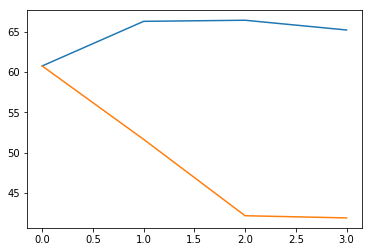

In [4]:
def tree_test():
    X, y = load_data()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

    err = []
    test_err = []
    for i in range(1, 5):
        tree = MyDecisionTreeRegressor(max_depth=i)
        tree.fit(X_train, y_train)
        err.append(np.linalg.norm(tree.predict(X_test) - y_test))

        test_tree = DecisionTreeRegressor(max_depth=i, criterion='mse')
        test_tree.fit(X_train, y_train)
        test_err.append(np.linalg.norm(test_tree.predict(X_test) - y_test))

    print err
    print
    print test_err
    plt.plot(err, label='my')
    plt.plot(test_err, label='test')
    plt.show()


tree_test()